In [37]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [38]:
# set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

# set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

| using device: cuda


In [39]:
# hyperparams
bsz = 10
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

## Data

Files already downloaded and verified
Files already downloaded and verified


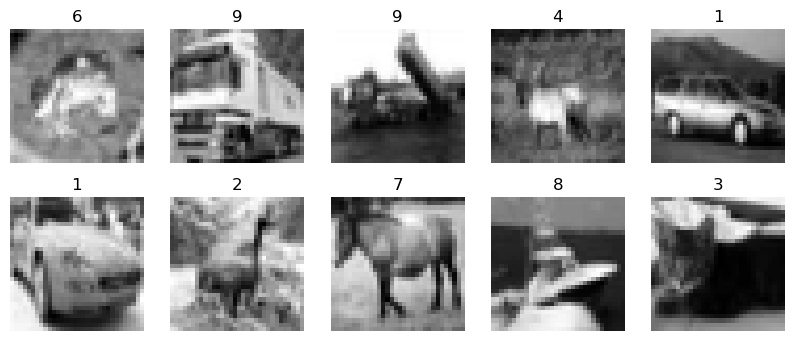

In [40]:
train_data, test_data = fetch_dataset()

test_loader = torch.utils.data.DataLoader(test_data, batch_size = 32, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [41]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)

noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)

50000
0


iid:  tensor([44., 51., 55., 46., 48., 57., 56., 50., 50., 43.])


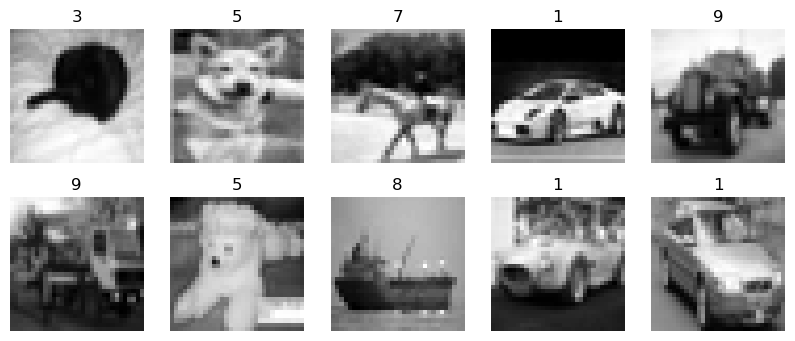

In [42]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([250.,   0.,   0., 250.,   0.,   0.,   0.,   0.,   0.,   0.])


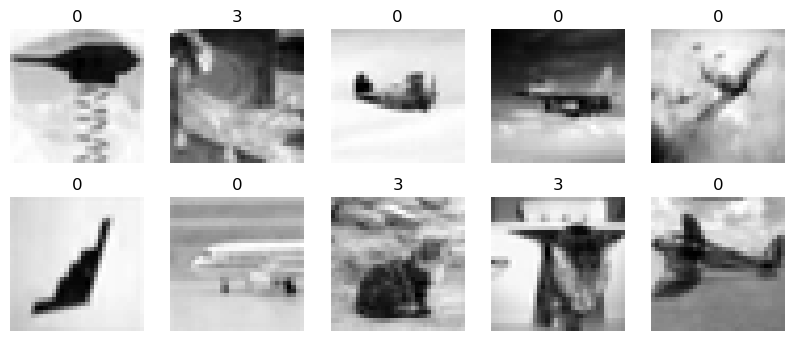

In [43]:
# non-iid
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

## Models

In [44]:
# define fully connected NN
from util import num_params
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # [B x 784]
        x = F.relu(self.fc1(x)) # [B x 200]
        x = F.relu(self.fc2(x)) # [B x 200]
        x = self.out(x) # [B x 10]
        return x

print(MLP())
print(num_params(MLP()))

MLP(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
656810


In [51]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64,kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(128*4*4, 128) # [64*4*4, 64*5*5]
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x,1) # [B x 1024]
        x = F.relu(self.fc(x)) # [B x 512]
        x = self.out(x) # [B x 10]
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=2048, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
356810


## Training

In [52]:
criterion = nn.CrossEntropyLoss()

def validate(model):
    model = model.to("cuda")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to("cuda")
            y = y.to("cuda")
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [53]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to("cuda")
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to("cuda")
            y = y.to("cuda")
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current

In [54]:
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to("cpu")
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)
        
        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


 ## MLP experiments

In [13]:
mlp = MLP()
print(mlp)
print("total params: ", num_params(mlp))

MLP(
  (fc1): Linear(in_features=3072, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
total params:  656810


In [61]:
# MLP - iid - m=10 experiment
mlp_iid_m10 = copy.deepcopy(mlp)
acc_mlp_iid_m10 = fed_avg_experiment(mlp_iid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.0001,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m10')
print(acc_mlp_iid_m10)
np.save('./acc_mlp_iid_m10.npy', acc_mlp_iid_m10)

starting round 0
clients:  [26 86  2 55 75 93 16 73 54 95]
round 0, starting client 1/10, id: 26
round 0, starting client 2/10, id: 86
round 0, starting client 3/10, id: 2
round 0, starting client 4/10, id: 55
round 0, starting client 5/10, id: 75
round 0, starting client 6/10, id: 93
round 0, starting client 7/10, id: 16
round 0, starting client 8/10, id: 73
round 0, starting client 9/10, id: 54
round 0, starting client 10/10, id: 95
round 0, validation acc: 0.1435
starting round 1
clients:  [18 29 64 92 72 87  5 15 12 17]
round 1, starting client 1/10, id: 18
round 1, starting client 2/10, id: 29
round 1, starting client 3/10, id: 64
round 1, starting client 4/10, id: 92
round 1, starting client 5/10, id: 72
round 1, starting client 6/10, id: 87
round 1, starting client 7/10, id: 5
round 1, starting client 8/10, id: 15
round 1, starting client 9/10, id: 12
round 1, starting client 10/10, id: 17
round 1, validation acc: 0.1454
starting round 2
clients:  [42 96 58 14 72  4 47 64 57 63]

In [62]:
# MLP - iid - m=50 experiment
mlp_iid_m50 = copy.deepcopy(mlp)
acc_mlp_iid_m50 = fed_avg_experiment(mlp_iid_m50, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.0001,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=100,
                                 filename='./acc_mlp_iid_m50')
print(acc_mlp_iid_m50)
np.save('./acc_mlp_iid_m50.npy', acc_mlp_iid_m50)

starting round 0
clients:  [79 10 44  4  7 45 26 32 49 39 55 97 63 29 23 72 34 73  9 88 83 91 19 54
 36  8 78 50  2 16 66 95 56 98 52 28 89 74  0 21 42 24 93 59 60 75 38 81
  1 87]
round 0, starting client 1/50, id: 79
round 0, starting client 2/50, id: 10
round 0, starting client 3/50, id: 44
round 0, starting client 4/50, id: 4
round 0, starting client 5/50, id: 7
round 0, starting client 6/50, id: 45
round 0, starting client 7/50, id: 26
round 0, starting client 8/50, id: 32
round 0, starting client 9/50, id: 49
round 0, starting client 10/50, id: 39
round 0, starting client 11/50, id: 55
round 0, starting client 12/50, id: 97
round 0, starting client 13/50, id: 63
round 0, starting client 14/50, id: 29
round 0, starting client 15/50, id: 23
round 0, starting client 16/50, id: 72
round 0, starting client 17/50, id: 34
round 0, starting client 18/50, id: 73
round 0, starting client 19/50, id: 9
round 0, starting client 20/50, id: 88
round 0, starting client 21/50, id: 83
round 0, sta

In [63]:
# MLP - non-iid - m=10 experiment
mlp_noniid_m10 = copy.deepcopy(mlp)
acc_mlp_noniid_m10 = fed_avg_experiment(mlp_noniid_m10, num_clients_per_round=10, 
                                 num_local_epochs=5,
                                 lr=0.0001,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename = './acc_mlp_noniid_m10')
print(acc_mlp_noniid_m10)
np.save('./acc_mlp_noniid_m10.npy', acc_mlp_noniid_m10)

starting round 0
clients:  [31 95  3  7 10 72 15 23 53 77]
round 0, starting client 1/10, id: 31
round 0, starting client 2/10, id: 95
round 0, starting client 3/10, id: 3
round 0, starting client 4/10, id: 7
round 0, starting client 5/10, id: 10
round 0, starting client 6/10, id: 72
round 0, starting client 7/10, id: 15
round 0, starting client 8/10, id: 23
round 0, starting client 9/10, id: 53
round 0, starting client 10/10, id: 77
round 0, validation acc: 0.1356
starting round 1
clients:  [68 32 59 67 37 72 90 10 77 89]
round 1, starting client 1/10, id: 68
round 1, starting client 2/10, id: 32
round 1, starting client 3/10, id: 59
round 1, starting client 4/10, id: 67
round 1, starting client 5/10, id: 37
round 1, starting client 6/10, id: 72
round 1, starting client 7/10, id: 90
round 1, starting client 8/10, id: 10
round 1, starting client 9/10, id: 77
round 1, starting client 10/10, id: 89
round 1, validation acc: 0.1221
starting round 2
clients:  [88 37 33 91 14 49 68 59 67 45]

In [64]:
# MLP - noniid - m=50 experiment
mlp_noniid_m50 = copy.deepcopy(mlp)
acc_mlp_noniid_m50 = fed_avg_experiment(mlp_noniid_m50, num_clients_per_round=50,
                                 num_local_epochs=5,
                                 lr=0.0001,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_mlp_noniid_m50')
print(acc_mlp_noniid_m50)
np.save('./acc_mlp_noniid_m50.npy', acc_mlp_noniid_m50)

starting round 0
clients:  [10 15 71 83 53  3 97 50 61 59 51  7 40 20 86 82  9 44 29 99 16  2 35 69
 63 77  1 23 85 25 49 57 74 79 52 88 18 98 93  4 95 28  6 56 32 39 62 12
 34 76]
round 0, starting client 1/50, id: 10
round 0, starting client 2/50, id: 15
round 0, starting client 3/50, id: 71
round 0, starting client 4/50, id: 83
round 0, starting client 5/50, id: 53
round 0, starting client 6/50, id: 3
round 0, starting client 7/50, id: 97
round 0, starting client 8/50, id: 50
round 0, starting client 9/50, id: 61
round 0, starting client 10/50, id: 59
round 0, starting client 11/50, id: 51
round 0, starting client 12/50, id: 7
round 0, starting client 13/50, id: 40
round 0, starting client 14/50, id: 20
round 0, starting client 15/50, id: 86
round 0, starting client 16/50, id: 82
round 0, starting client 17/50, id: 9
round 0, starting client 18/50, id: 44
round 0, starting client 19/50, id: 29
round 0, starting client 20/50, id: 99
round 0, starting client 21/50, id: 16
round 0, sta

## CNN Experiments

In [55]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=2048, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)
total params:  356810


In [56]:
# CNN - iid - m=10 experiment
cnn_iid_m10 = copy.deepcopy(cnn)
acc_cnn_iid_m10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_iid_m10')
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_m10.npy', acc_cnn_iid_m10)

starting round 0
clients:  [18 29 64 92 72 87  5 15 12 17]
round 0, starting client 1/10, id: 18
round 0, starting client 2/10, id: 29
round 0, starting client 3/10, id: 64
round 0, starting client 4/10, id: 92
round 0, starting client 5/10, id: 72
round 0, starting client 6/10, id: 87
round 0, starting client 7/10, id: 5
round 0, starting client 8/10, id: 15
round 0, starting client 9/10, id: 12
round 0, starting client 10/10, id: 17
round 0, validation acc: 0.1743
starting round 1
clients:  [42 96 58 14 72  4 47 64 57 63]
round 1, starting client 1/10, id: 42
round 1, starting client 2/10, id: 96
round 1, starting client 3/10, id: 58
round 1, starting client 4/10, id: 14
round 1, starting client 5/10, id: 72
round 1, starting client 6/10, id: 4
round 1, starting client 7/10, id: 47
round 1, starting client 8/10, id: 64
round 1, starting client 9/10, id: 57
round 1, starting client 10/10, id: 63
round 1, validation acc: 0.202
starting round 2
clients:  [54 84 33 53  2 49 48 82 41 66]


In [57]:
# CNN - iid - m=50 experiment
cnn_iid_m50 = copy.deepcopy(cnn)
acc_cnn_iid_m50 = fed_avg_experiment(cnn_iid_m50, num_clients_per_round=10,
                                 num_local_epochs=10,
                                 lr=0.01,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_iid_m50')
print(acc_cnn_iid_m50)
np.save('./acc_cnn_iid_m50.npy', acc_cnn_iid_m50)

starting round 0
clients:  [68 32 59 67 37 72 90 10 77 89]
round 0, starting client 1/10, id: 68
round 0, starting client 2/10, id: 32
round 0, starting client 3/10, id: 59
round 0, starting client 4/10, id: 67
round 0, starting client 5/10, id: 37
round 0, starting client 6/10, id: 72
round 0, starting client 7/10, id: 90
round 0, starting client 8/10, id: 10
round 0, starting client 9/10, id: 77
round 0, starting client 10/10, id: 89
round 0, validation acc: 0.2002
starting round 1
clients:  [88 37 33 91 14 49 68 59 67 45]
round 1, starting client 1/10, id: 88
round 1, starting client 2/10, id: 37
round 1, starting client 3/10, id: 33
round 1, starting client 4/10, id: 91
round 1, starting client 5/10, id: 14
round 1, starting client 6/10, id: 49
round 1, starting client 7/10, id: 68
round 1, starting client 8/10, id: 59
round 1, starting client 9/10, id: 67
round 1, starting client 10/10, id: 45
round 1, validation acc: 0.3083
starting round 2
clients:  [99 74  6 83 73 34 19 35 71 2

In [58]:
# CNN - non-iid - m=10 experiment
cnn_noniid_m10 = copy.deepcopy(cnn)
acc_cnn_noniid_m10 = fed_avg_experiment(cnn_noniid_m10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m10')
print(acc_cnn_noniid_m10)
np.save('./acc_cnn_noniid_m10.npy', acc_cnn_noniid_m10)

starting round 0
clients:  [88 75 29  4  2 43 81 60 17 14]
round 0, starting client 1/10, id: 88
round 0, starting client 2/10, id: 75
round 0, starting client 3/10, id: 29
round 0, starting client 4/10, id: 4
round 0, starting client 5/10, id: 2
round 0, starting client 6/10, id: 43
round 0, starting client 7/10, id: 81
round 0, starting client 8/10, id: 60
round 0, starting client 9/10, id: 17
round 0, starting client 10/10, id: 14
round 0, validation acc: 0.1038
starting round 1
clients:  [71 29 11 81 34  8 94 30 64 96]
round 1, starting client 1/10, id: 71
round 1, starting client 2/10, id: 29
round 1, starting client 3/10, id: 11
round 1, starting client 4/10, id: 81
round 1, starting client 5/10, id: 34
round 1, starting client 6/10, id: 8
round 1, starting client 7/10, id: 94
round 1, starting client 8/10, id: 30
round 1, starting client 9/10, id: 64
round 1, starting client 10/10, id: 96
round 1, validation acc: 0.1029
starting round 2
clients:  [47 31 54 11 29  5 74 15 69 76]


In [59]:
# CNN - non-iid - m=50 experiment
cnn_noniid_m50 = copy.deepcopy(cnn)
acc_cnn_noniid_m50 = fed_avg_experiment(cnn_noniid_m50, num_clients_per_round=10,
                                 num_local_epochs=10,
                                 lr=0.01,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=200,
                                 filename='./acc_cnn_noniid_m50')
print(acc_cnn_noniid_m50)
np.save('./acc_cnn_noniid_m50.npy', acc_cnn_noniid_m50)

starting round 0
clients:  [51  0 18 52 79  5 67 56 89  2]
round 0, starting client 1/10, id: 51
round 0, starting client 2/10, id: 0
round 0, starting client 3/10, id: 18
round 0, starting client 4/10, id: 52
round 0, starting client 5/10, id: 79
round 0, starting client 6/10, id: 5
round 0, starting client 7/10, id: 67
round 0, starting client 8/10, id: 56
round 0, starting client 9/10, id: 89
round 0, starting client 10/10, id: 2
round 0, validation acc: 0.1043
starting round 1
clients:  [25 77 54 43 93 30 85  8 27 28]
round 1, starting client 1/10, id: 25
round 1, starting client 2/10, id: 77
round 1, starting client 3/10, id: 54
round 1, starting client 4/10, id: 43
round 1, starting client 5/10, id: 93
round 1, starting client 6/10, id: 30
round 1, starting client 7/10, id: 85
round 1, starting client 8/10, id: 8
round 1, starting client 9/10, id: 27
round 1, starting client 10/10, id: 28
round 1, validation acc: 0.1877
starting round 2
clients:  [76  7 96 45 67 71 20  1 30 48]
r

In [70]:
# view_10(x_debug[:10].to(cpu), torch.argmax(model(x_debug),dim=1)[:10].to(cpu))

# m = CNN().to(cuda)
# m.train()
# lr = 0.01
# opt = torch.optim.SGD(m.parameters(), lr)

# for epoch in range(5):
#     for (t, (x,y)) in enumerate(train_loader):
#         x = x.to(cuda)
#         y = y.to(cuda)
#         opt.zero_grad()
#         out = m(x)
#         loss = criterion(out, y)
#         loss.backward()
#         opt.step()

#         if (t%100 == 0):
#             print("epoch {}, step {}, loss: {}".format(epoch, t, loss))

#     print("running validation")
#     acc = validate(m)
#     print("epoch {} validation acc: {}".format(epoch, acc))